# **Build the model for Multi-task Learning**

Backbone: MobileNetV3
Heads: Lightweight Refine Net

refs:
- MobileNetV3: https://arxiv.org/pdf/1905.02244.pdf
- Refine Net: https://arxiv.org/pdf/1611.06612.pdf
- LightWeight Refine Net: https://arxiv.org/pdf/1810.03272.pdf
- Realtime Multi-Task Learning: https://arxiv.org/pdf/1809.04766.pdf

In [1]:
import os

import numpy as np
import h5py
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torchvision.models import resnet50, mobilenet_v3_small
# from torchvision.models.segmentation.lraspp import LRASPP
# seg_head = LRASPP(mobilenet_backbone, low_channels, high_channels, num_classes=31)

mobilenet_backbone = mobilenet_v3_small(weights='IMAGENET1K_V1')

In [3]:

for i in range(len(mobilenet_backbone.features)):
    print(i, mobilenet_backbone.features[i]._get_name())


0 Conv2dNormActivation
1 InvertedResidual
2 InvertedResidual
3 InvertedResidual
4 InvertedResidual
5 InvertedResidual
6 InvertedResidual
7 InvertedResidual
8 InvertedResidual
9 InvertedResidual
10 InvertedResidual
11 InvertedResidual
12 Conv2dNormActivation


Construct the backbone by passing the input through all the feature extraction layers (expect the final layer). During training, we will freeze these layers since they have already been pretrained on image net. We will add the capability for skip connections in order to integrate the backbone to our Light Weight Refine Net heads.

In [4]:
class MobileNetV3Backbone(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
    
    def forward(self, x):
        """ Passes input theough MobileNetV3 backbone feature extraction layers
            layers to add connections to
                - 1:  1/4 res
                - 3:  1/8 res
                - 7, 8:  1/16 res
                - 10, 11: 1/32 res
           """
        skips = nn.ParameterDict()
        for i in range(len(self.backbone) - 1):
            x = self.backbone[i](x)
            # print(i, x.shape)
            # add skip connection outputs
            if i in [1, 3, 7, 8, 10, 11]:
                skips.update({f"l{i}_out" : x})

        return skips


In [5]:
backbone = MobileNetV3Backbone(mobilenet_backbone.features)

test = torch.rand((1, 3, 512, 512)).float()

skips = backbone(test)
print(skips.keys())

dict_keys(['l1_out', 'l3_out', 'l7_out', 'l8_out', 'l10_out', 'l11_out'])


In [6]:
skips

ParameterDict(
    (l1_out): Parameter containing: [torch.FloatTensor of size 1x16x128x128]
    (l3_out): Parameter containing: [torch.FloatTensor of size 1x24x64x64]
    (l7_out): Parameter containing: [torch.FloatTensor of size 1x48x32x32]
    (l8_out): Parameter containing: [torch.FloatTensor of size 1x48x32x32]
    (l10_out): Parameter containing: [torch.FloatTensor of size 1x96x16x16]
    (l11_out): Parameter containing: [torch.FloatTensor of size 1x96x16x16]
)

## **Define Lightweight Refine Net**

ref:
    https://github.com/DrSleep/multi-task-refinenet/blob/master/src/models.py

In [7]:

# # Chained Residual Pooling
# class CRPBlock(nn.Module):
#     def __init__(self, in_chans, out_chans, n_stages=4, groups=False):
#         super().__init__()

#         self.n_stages = n_stages
#         groups = in_chans if groups else 1

#         self.max_pool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

#         self.mini_blocks = []
#         for i in range(n_stages):
#             # self.mini_blocks.append(
#             #     nn.Sequential(
#             #         *nn.ModuleList(
#             #             [nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False, groups=groups),
#             #              nn.MaxPool2d(kernel_size=5, stride=1, padding=2)])))

#             self.mini_blocks.append(
#                         self.register_parameter(name=f"crp_{i}",
#                                                 param=nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False, groups=groups)))
#         out = x
#         for block in self.mini_blocks:
#             out = block(out)
#             out = self.max_pool(out)
#             x = x + out

#         return x


# # Chained Residual Pooling
# class CRPBlock(nn.Module):
#     def __init__(self, in_chans, out_chans, n_stages=4, groups=False):
#         super().__init__()

#         self.n_stages = n_stages
#         groups = in_chans if groups else 1

#         self.max_pool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

#         self.mini_blocks = []
#         for i in range(n_stages):
#             # self.mini_blocks.append(
#             #     nn.Sequential(
#             #         *nn.ModuleList(
#             #             [nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False, groups=groups),
#             #              nn.MaxPool2d(kernel_size=5, stride=1, padding=2)])))

#             # self.mini_blocks.append(
#             #             self.register_parameter(name=f"crp_{i}",
#             #                                     param=nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False, groups=groups)))

#             self.mini_blocks.append(
#                 nn.Sequential(
#                     nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False, groups=groups),
#                     nn.MaxPool2d(kernel_size=5, stride=1, padding=2)))
            
#     def forward(self, x):
#         out = x
#         for block in self.mini_blocks:
#             out = block(out)
#             out = self.max_pool(out)
#             x = x + out

#         return x


# Chained Residual Pooling
class CRPBlock(nn.Module):
    def __init__(self, in_chans, out_chans, n_stages=4, groups=False):
        super().__init__()

        self.n_stages = n_stages
        groups = in_chans if groups else 1

        self.max_pool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

        self.mini_blocks = nn.ModuleList()

        for _ in range(n_stages):
            self.mini_blocks.append(nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False, groups=groups))
            self.mini_blocks.append(nn.MaxPool2d(kernel_size=5, stride=1, padding=2))

       
    def forward(self, x):
        out = x
        for block in self.mini_blocks:
            out = block(out)
            # out = self.max_pool(out)
            x = x + out

        return x


# # from source
# def conv1x1(in_planes, out_planes, stride=1, bias=False, groups=1):
#     "1x1 convolution"
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
#                      padding=0, bias=bias, groups=groups)

# class CRPBlock(nn.Module):
#     """CRP definition"""
#     def __init__(self, in_planes, out_planes, n_stages=4, groups=False):
#         super(CRPBlock, self).__init__()
#         for i in range(n_stages):
#             setattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'),
#                     conv1x1(in_planes if (i == 0) else out_planes,
#                             out_planes, stride=1,
#                             bias=False, groups=in_planes if groups else 1))
#         self.stride = 1
#         self.n_stages = n_stages
#         self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

#     def forward(self, x):
#         top = x
#         for i in range(self.n_stages):
#             top = self.maxpool(top)
#             top = getattr(self, '{}_{}'.format(i + 1, 'outvar_dimred'))(top)
#             x = top + x
#         return x

In [8]:
test = torch.rand((1, 256, 16, 16))

crp = CRPBlock(256, 256)

out = crp(test)
out.shape

torch.Size([1, 256, 16, 16])

In [9]:
class LightWeightRefineNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # 1x1 convs to convert encoder channels to 256
        self.conv1 = nn.Conv2d(96, 256, kernel_size=1, stride=1, bias=False) # 1/32 res
        self.conv2 = nn.Conv2d(96, 256, kernel_size=1, stride=1, bias=False) # 1/32 res
        self.conv3 = nn.Conv2d(48, 256, kernel_size=1, stride=1, bias=False) # 1/16 res
        self.conv4 = nn.Conv2d(48, 256, kernel_size=1, stride=1, bias=False) # 1/16 res
        self.conv5 = nn.Conv2d(24, 256, kernel_size=1, stride=1, bias=False) # 1/8 res
        self.conv6 = nn.Conv2d(16, 256, kernel_size=1, stride=1, bias=False) # 1/4 res

        # CRP Blocks
        self.crp1 = CRPBlock(256, 256, 4, groups=False)
        self.crp2 = CRPBlock(256, 256, 4, groups=False)
        self.crp3 = CRPBlock(256, 256, 4, groups=False)
        self.crp4 = CRPBlock(256, 256, 4, groups=True)

        self.conv_adapt1 = nn.Conv2d(256, 256, kernel_size=1, stride=1, bias=False)
        self.conv_adapt2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, bias=False)
        self.conv_adapt3 = nn.Conv2d(256, 256, kernel_size=1, stride=1, bias=False)


        # output heads
        self.pre_depth = nn.Conv2d(256, 256, kernel_size=1, groups=256, bias=False)
        self.depth = nn.Conv2d(256, 1, kernel_size=3, padding=1, bias=True)

        self.pre_seg = nn.Conv2d(256, 256, kernel_size=1, groups=256, bias=False)
        self.seg = nn.Conv2d(256, num_classes, kernel_size=3, padding=1, bias=True)

        self.relu6 = nn.ReLU6(inplace=True)


    def forward(self, skips):
        # ['l1_out', 'l3_out', 'l7_out', 'l8_out', 'l10_out', 'l11_out']

        # smallest res CRP skip
        l11 = self.conv1(skips['l11_out'])
        l10 = self.conv2(skips['l10_out'])
        l10 = self.relu6(l10 + l11)
        l10 = self.crp1(l10)
        l10 = self.conv_adapt1(l10)
        l10 = nn.Upsample(size=skips['l8_out'].size()[2:], mode='bilinear', align_corners=False)(l10)

        l8 = self.conv3(skips['l8_out'])
        l7 = self.conv4(skips['l7_out'])
        l7 = self.relu6(l7 + l8 + l10)
        l7 = self.crp2(l7)
        l7 = self.conv_adapt3(l7)
        l7 = nn.Upsample(size=skips['l3_out'].size()[2:], mode='bilinear', align_corners=False)(l7)

        l3 = self.conv5(skips['l3_out'])
        l3 = self.relu6(l7 + l3)
        l3 = self.crp3(l3)
        l3 = self.conv_adapt2(l3)
        l3 = nn.Upsample(size=skips['l1_out'].size()[2:], mode='bilinear', align_corners=False)(l3)

        # largest res CRP skip
        l1 = self.conv6(skips['l1_out'])
        l1 = self.relu6(l1 + l3)
        l1 = self.crp4(l1)

        # pass through output heads
        out_seg = self.pre_seg(l3)
        out_seg = self.relu6(out_seg)
        out_seg = self.seg(out_seg)

        out_depth = self.pre_depth(l3)
        out_depth = self.relu6(out_depth)
        out_depth = self.depth(out_depth)

        return out_seg, out_depth

In [10]:
decoder = LightWeightRefineNet(6)

In [11]:
out = decoder(skips)
out[0].shape, out[1].shape

(torch.Size([1, 6, 128, 128]), torch.Size([1, 1, 128, 128]))

Place Encoder and Decoder into MultiTask Model

In [12]:
class MultiTaskNetwork(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    
    def forward(self, x):
        height, width = x.size()[-2:]

        skips = self.encoder(x)
        out_seg, out_depth = self.decoder(skips)
        
        out_seg = nn.Upsample(size=(height, width), mode='bilinear', align_corners=False)(out_seg)
        out_depth = nn.Upsample(size=(height, width), mode='bilinear', align_corners=False)(out_depth)
        
        return out_seg, out_depth


In [27]:
encoder = MobileNetV3Backbone(mobilenet_backbone.features)
decoder = LightWeightRefineNet(6)
model = MultiTaskNetwork(encoder, decoder)

# model = nn.DataParallel(nn.Sequential(encoder, decoder))
# model = nn.Sequential(encoder, decoder)

Can not store the skips on GPU, so we need to be sure that we register them as buffers

https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723
https://stackoverflow.com/questions/60796555/certain-members-of-a-torch-module-arent-moved-to-gpu-even-if-model-todevice-i


In [14]:
test = torch.rand((1, 3, 256, 512))
# model.to('cpu')
out_seg, out_depth = model(test)

print(out_seg.size(), out_depth.size())

torch.Size([1, 6, 256, 512]) torch.Size([1, 1, 256, 512])


In [33]:
next(decoder.crp1.parameters()).is_cuda

False

In [34]:
next(decoder.conv1.parameters()).is_cuda

False

In [50]:
model.to('cuda')
out_seg, out_depth = model(test.to('cuda'))

In [51]:
# encoder.to('cuda')
# out_dict = encoder(test.to('cuda'))
# out_dict.keys()

dict_keys(['l1_out', 'l3_out', 'l7_out', 'l8_out', 'l10_out', 'l11_out'])

In [ ]:
# out_dict['l1_out']

In [35]:
root = "C:/Users/itber/Documents/datasets/cityscapes"
OG_W, OG_H = 2048, 1024   # OG width adn height
W1, H1 = OG_W, OG_H # resize w,h for dataloader
W2, H2 = W1//2, H1//2     # resize w,h for model inference

device = 'cpu' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CityScapesDataset(Dataset):
    def __init__(self, root, transform=None, split='train'):
        self.root = root
        self.transform = transform

        self.left_paths = glob(os.path.join(root, 'leftImg8bit', split, '**\*.png'))
        self.mask_paths = glob(os.path.join(root, 'gtFine', split, '**\*gtFine_labelIds.png'))
        self.depth_paths = glob(os.path.join(root, 'crestereo_depth', split, '**\*.png'))
        # self.depth_paths = glob(os.path.join(root, 'crestereo_disparity', split, '**\*.png')) 
        # self.depth_paths = glob(os.path.join(root, 'disparity', split, '**\*.png')) 

        sorted(self.left_paths)
        sorted(self.mask_paths)
        sorted(self.depth_paths)


    def __getitem__(self, idx):
        left = cv2.cvtColor(cv2.imread(self.left_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_UNCHANGED).astype(np.int32)
        depth = cv2.imread(self.depth_paths[idx], cv2.IMREAD_UNCHANGED) # .astype(np.int32)

        # normalize depth
        depth = cv2.normalize(depth, dst=None, alpha=1e-3, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        if self.transform:
            left = self.transform(left)
            mask = self.transform(mask)
            depth = self.transform(depth)

        return left, mask, depth
    
    def __len__(self):
        return len(self.left_paths)
    


In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((H2, W2)),
])

In [38]:
BATCH_SIZE = 2
NUM_CLASSES = 34

train_dataset = CityScapesDataset(root, transform=transform, split='val')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

In [17]:
import torch.optim as optim

# place model on device before declaring optimizer
encoder = MobileNetV3Backbone(mobilenet_backbone.features)
decoder = LightWeightRefineNet(NUM_CLASSES)
model = MultiTaskNetwork(encoder, decoder)

model.to(device);

optimizer = optim.Adam(model.parameters(), lr=1e-4)
seg_criterion = nn.CrossEntropyLoss()
depth_criterion = nn.MSELoss()

In [18]:
# # define loss weights
# CE_W = 1.
# DICE_W = 0.


# # loss function
# def seg_criterion(pred, target):

#     # NOTE: order matters for this loss function
#     if DICE_W != 0:
#         dice_loss = tgm.losses.DiceLoss()(pred, target.to(torch.long)) 
#     else:
#         dice_loss = 0.

#     # reshape for cross entropy loss
#     if CE_W != 0:
#         cross_entropy_loss = \
#             nn.CrossEntropyLoss()(
#                 pred.view(BATCH_SIZE, 6, -1), 
#                 target.view(BATCH_SIZE, -1).to(torch.long))
#     else:
#         cross_entropy_loss = 0    

#     # get combined loss
#     loss =  CE_W*cross_entropy_loss + DICE_W*dice_loss

#     return loss

def seg_criterion(pred, target):

    return nn.CrossEntropyLoss()(
                pred.view(BATCH_SIZE, NUM_CLASSES, -1), 
                target.view(BATCH_SIZE, -1).to(torch.long))

In [19]:
next(model.parameters()).is_cuda

False

In [20]:
def compute_iou(targets, predictions):

    # targets = targets.reshape(-1)
    # predictions = predictions.reshape(-1)

    targets = targets.view(BATCH_SIZE, -1).to(torch.long)
    predictions = predictions.argmax(dim=1).view(BATCH_SIZE, -1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

In [21]:
device = 'cuda'

In [23]:
epochs = 10

model.to(device)

avg_seg_loss = []
avg_depth_loss = []
avg_seg_iou = []

for e in range(epochs):

    seg_losses = []
    depth_losses = []
    seg_ious = []

    model.train()


    for i, (left, mask, depth) in enumerate(train_loader):
        left, mask, depth = left.to(device), mask.to(device), depth.to(device)

        # get predictions
        pred_seg, pred_depth = model(left)

        # compute losses
        # seg_loss = seg_criterion(mask.squeeze(1).long(), pred_seg.argmax(dim=1))
        seg_loss = seg_criterion(pred_seg, mask)
        depth_loss = depth_criterion(depth, pred_depth)
        loss = seg_loss + depth_loss

        # zero gradients (must do before backprop?)
        optimizer.zero_grad()

        # back prop loss
        loss.backward()

        # step weights
        optimizer.step()

        # store metrics
        seg_losses.append(seg_loss.item())
        depth_losses.append(depth_loss.item())
        seg_ious.append(compute_iou(mask.detach().cpu(), pred_seg.detach().cpu()).numpy())


    # get avg losses
    avg_seg_loss.append(np.mean(seg_losses))
    avg_depth_loss.append(np.mean(depth_losses))
    avg_seg_iou.append(np.mean(seg_ious))

    print(avg_seg_loss[-1])
    print(avg_depth_loss[-1])
    print(avg_seg_iou[-1])
        

1.3456412577629089
0.045286968680098655
-1.0000077
0.9158493747711182
0.02073315082117915
-1.0000052
0.8163911937475204
0.01789055390097201
-1.0000051
0.752240944981575
0.01697712268680334
-1.0000049
0.6959144014120102
0.016280804172158242
-1.0000049
0.6475832744836807
0.015770887238904834
-1.0000048
0.6051936634778976
0.01535535822249949
-1.0000046
0.5656136095523834
0.015132615134119988
-1.0000046
0.5328537979125977
0.014902482824400067
-1.0000045
0.5094176957607269
0.014894558999687434
-1.0000045


In [27]:
left.shape, mask.shape, pred_seg.shape, pred_depth.shape

(torch.Size([2, 3, 512, 1024]),
 torch.Size([2, 1, 512, 1024]),
 torch.Size([2, 34, 512, 1024]),
 torch.Size([2, 1, 512, 1024]))

In [30]:
left.detach().cpu().numpy().transpose(0, 2, 3, 1).shape

(2, 512, 1024, 3)

In [35]:
pred_seg.argmax(dim=1).shape

torch.Size([2, 512, 1024])

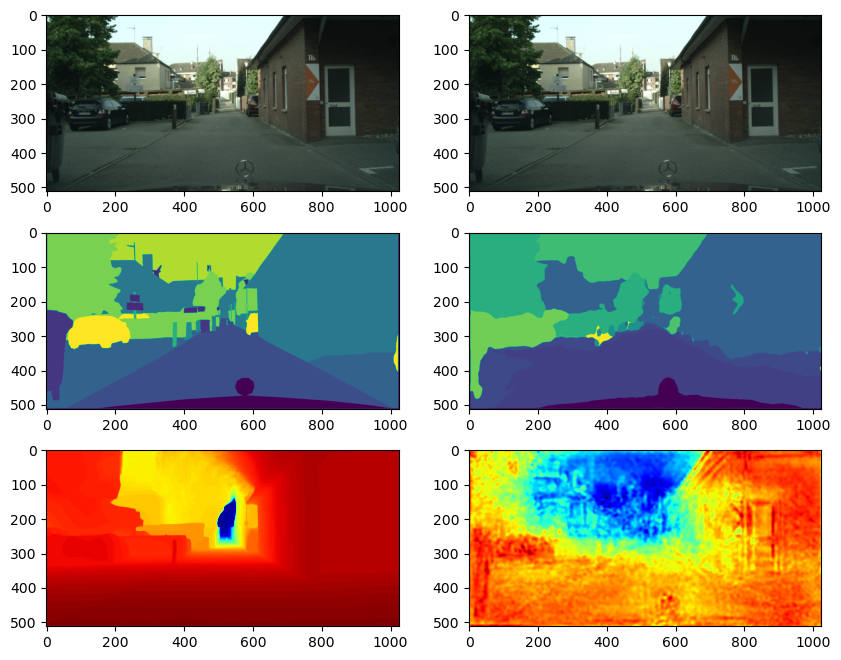

In [50]:
idx = 1

_, ax = plt.subplots(3, 2, figsize=(10, 8))
ax[0, 0].imshow(left.detach().cpu().numpy().transpose(0, 2, 3, 1)[idx])
ax[1, 0].imshow(mask.detach().cpu().numpy().squeeze(1)[idx])
ax[2, 0].imshow(depth.detach().cpu().numpy().squeeze(1)[idx], cmap='jet_r')

ax[0, 1].imshow(left.detach().cpu().numpy().transpose(0, 2, 3, 1)[idx])
ax[1, 1].imshow(pred_seg.argmax(dim=1).detach().cpu().numpy()[idx])
ax[2, 1].imshow(pred_depth.detach().cpu().numpy().squeeze(1)[idx], cmap='jet_r')

In [49]:
depth.min(), depth.max(), pred_depth.min(), pred_depth.max()

(tensor(0.0010, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(-0.2503, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.5998, device='cuda:0', grad_fn=<MaxBackward1>))

Encoder pretrained on imagenet

Assumption: ImageNet is diverse enough to allow robust encoding for all target domain input images

In [62]:
i

0

In [80]:
print(pred_seg.view(2, NUM_CLASSES, -1).shape), print(mask.view(2, -1).shape)

torch.Size([2, 34, 524288])
torch.Size([2, 524288])


(None, None)

In [85]:
pred_seg.shape

torch.Size([2, 34, 512, 1024])

In [87]:
pred_seg.argmax(dim=1).view(BATCH_SIZE, -1).shape

torch.Size([2, 524288])

In [84]:
pred_seg.view(2, NUM_CLASSES, -1)

tensor([[[-0.0464, -0.0464, -0.0363,  ..., -0.1063, -0.0953, -0.0953],
         [ 0.1339,  0.1339,  0.1001,  ...,  0.2770,  0.2709,  0.2709],
         [ 0.3761,  0.3761,  0.3867,  ...,  0.0496,  0.0402,  0.0402],
         ...,
         [ 0.3802,  0.3802,  0.3457,  ..., -0.0430, -0.0182, -0.0182],
         [ 0.0136,  0.0136, -0.0645,  ..., -0.1378, -0.1523, -0.1523],
         [ 0.2772,  0.2772,  0.2672,  ...,  0.1176,  0.1138,  0.1138]],

        [[-0.2145, -0.2145, -0.2060,  ..., -0.0472, -0.0381, -0.0381],
         [ 0.3402,  0.3402,  0.3006,  ...,  0.1596,  0.1508,  0.1508],
         [ 0.3864,  0.3864,  0.4177,  ...,  0.1069,  0.0979,  0.0979],
         ...,
         [ 0.4387,  0.4387,  0.3976,  ..., -0.0164,  0.0215,  0.0215],
         [-0.0296, -0.0296, -0.1186,  ..., -0.1426, -0.1525, -0.1525],
         [ 0.2056,  0.2056,  0.1864,  ...,  0.1540,  0.1523,  0.1523]]],
       grad_fn=<ViewBackward0>)

In [65]:
len(torch.unique(mask))

31

In [45]:
pred_seg.max()

tensor(1.5314, grad_fn=<MaxBackward1>)

In [50]:
pred_seg.view(2, 6, -1)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [50]:
mask.shape, pred_seg.shape

(torch.Size([2, 1, 512, 1024]), torch.Size([2, 6, 512, 1024]))

In [51]:
pred_seg.argmax(dim=1).shape

torch.Size([2, 512, 1024])

In [64]:
next(model.parameters()).is_cuda

False

In [ ]:
mask

In [31]:
lbl

Label(name='license plate', id=-1, trainId=-1, category='vehicle', categoryId=7, hasInstances=False, ignoreInEval=True, color=(0, 0, 142))

In [21]:
from labels import labels

id_2_train = {}
id_2_cat = {}
train_2_id = {}
id_2_name = {255 : 'unlabeled', -1 : 'unlabeled'}

for lbl in labels:
    id_2_train.update({lbl.id : lbl.trainId})
    id_2_cat.update({lbl.id : lbl.categoryId})
    if (lbl.trainId > 0) and (lbl.trainId != 255):
        id_2_name.update({lbl.trainId : lbl.name})
        train_2_id.update({lbl.trainId : lbl.id})
        


In [23]:
label_map = ['id', 'trainId', 'catId']

assert ['id', 'trainId', 'catId'] in label_map

AssertionError: 

In [27]:
assert 'id', 'trainId' in label_map

In [84]:
left, mask, depth = train_dataset[100]
mask = convert_to_numpy(mask).squeeze()

In [90]:
import time

In [97]:
t = time.perf_counter()

tgt = np.zeros_like(mask)

for k, v in id_2_train.items():
    np.putmask(tgt, mask==k, v)


print(time.perf_counter() - t)

0.012797000000318803


In [98]:
mask2 = mask.copy()
t = time.perf_counter()


for k, v in id_2_train.items():
    mask2[mask == k] = v


print(time.perf_counter() - t)

0.004191699999864795


In [89]:
tgt.shape

(512, 1024)

In [88]:
np.sum(tgt == 255)

64

In [59]:
mask[mask == np.unique(mask)]

C:\Users\itber\AppData\Local\Temp\ipykernel_16372\780480165.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask[mask == np.unique(mask)]


array([], shape=(0, 512, 1024), dtype=int32)

In [52]:
np.unique(mask)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [68]:
tmp =np.place(mask, mask==3, -22)

In [83]:
np.put(mask, np.where(mask==30), 255)

In [81]:
mask.dtype

dtype('int32')

In [80]:
plt.imshow(tmp.astype(np.uint8))

AttributeError: 'NoneType' object has no attribute 'astype'

In [76]:
np.where(mask == 30)

(array([193, 194, 196, 197, 197, 197, 197, 199, 199, 199, 199, 200, 200,
        200, 201, 201, 201, 201, 202, 202, 202, 202, 203, 203, 204, 204,
        204, 205, 205, 205, 206, 206, 207, 208, 208, 208, 208, 208, 208,
        208, 208, 208, 209, 209, 209, 209, 209, 210, 210, 211, 211, 212,
        212, 212, 213, 213, 214, 215, 215, 216, 216, 217, 227, 232],
       dtype=int64),
 array([455, 452, 608, 524, 528, 529, 530, 523, 545, 589, 600, 272, 547,
        594, 454, 526, 549, 590, 529, 559, 560, 561, 606, 612, 213, 543,
        596, 211, 546, 583, 546, 580, 579, 187, 208, 271, 552, 553, 554,
        555, 556, 578, 180, 184, 546, 559, 560, 550, 560, 270, 557, 270,
        545, 554, 271, 549, 273, 453, 544, 197, 203, 174, 611, 451],
       dtype=int64))

In [69]:
np.sum(np.sum(tmp == -22))

0

In [58]:
mask[np.unique(mask)]

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 2, 3, 3],
       ...,
       [3, 3, 3, ..., 7, 3, 3],
       [3, 3, 3, ..., 7, 3, 3],
       [3, 3, 3, ..., 7, 3, 3]])

In [29]:
for k,v in id_2_train.items():
    print(k, v)

0 255
1 255
2 255
3 255
4 255
5 255
6 255
7 0
8 1
9 255
10 255
11 2
12 3
13 4
14 255
15 255
16 255
17 5
18 255
19 6
20 7
21 8
22 9
23 10
24 11
25 12
26 13
27 14
28 15
29 255
30 255
31 16
32 17
33 18
-1 -1


In [39]:
left, mask, depth = train_dataset[100]

In [43]:
def convert_to_numpy(image):
    return image.detach().cpu().numpy().transpose(1, 2, 0)

In [44]:
left, mask, depth = convert_to_numpy(left), convert_to_numpy(mask), convert_to_numpy(depth)

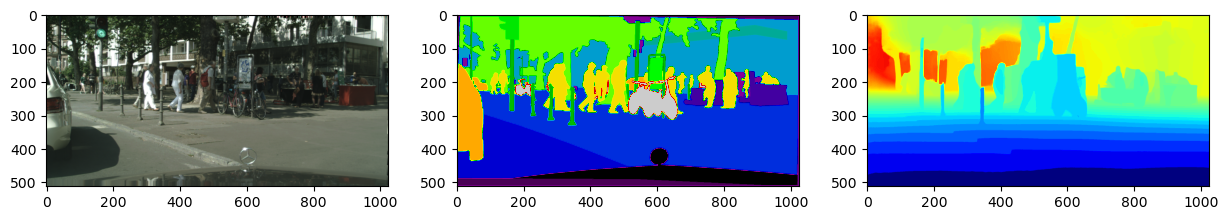

In [45]:
_, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(left)
ax[1].imshow(mask, cmap='nipy_spectral')
ax[2].imshow(np.log(depth + 0.01), cmap='jet')

In [501]:
disp_vis = (depth - depth.min()) / (depth.max() - depth.min()) # * 255.0

In [502]:
disp_vis.min(), disp_vis.max()

(0.0, 1.0)

In [503]:
depth.min(), depth.max()

(0.0010000002, 0.8468795)

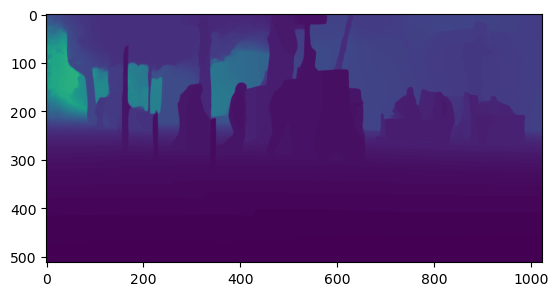

In [504]:
plt.imshow(disp_vis)

In [490]:
depth.min(), depth.max()

(0.01, 0.8482589)

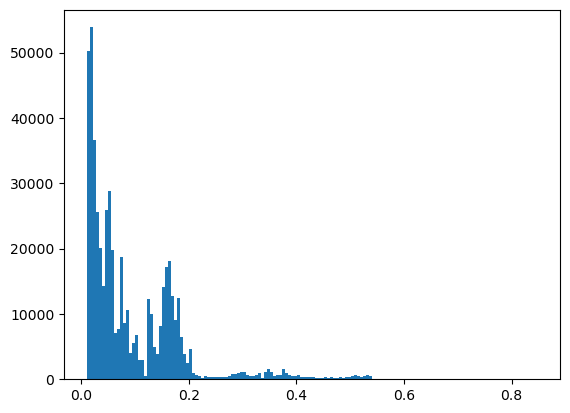

In [491]:
plt.hist(depth.flatten(), bins=150);

In [390]:
disparity = depth.astype(np.float32)
disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

disparity.min(), disparity.max()

(0.0, 126.0)

In [401]:
disparity = depth.astype(np.float32)
disparity[disparity > 0] = (disparity[disparity > 0] - 1) / 256

disparity.min(), disparity.max()

(-0.0038526347, -0.0019569546)

In [405]:
disp = cv2.normalize(depth, dst=None, alpha=0, beta=126, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

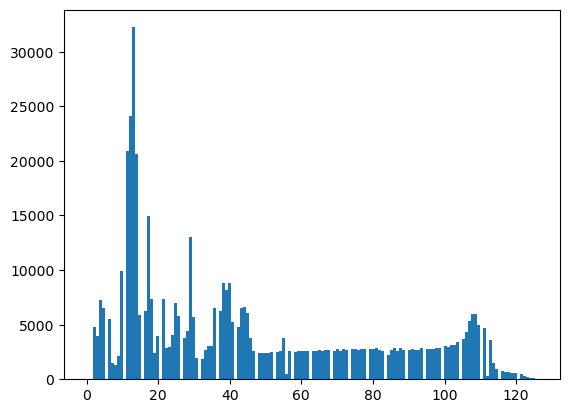

In [406]:
plt.hist(disp.flatten(), bins=150);

In [426]:
baseline = 0.209313 # meters
f = 2262.52 # x focal length (pixels)

pred_depth = np.clip(baseline * f / (disp + 0.1), 0, 500)

pred_depth = baseline * f / (depth + 0.1)

In [427]:
pred_depth.min(), pred_depth.max()

(790.5832, 4164.193)

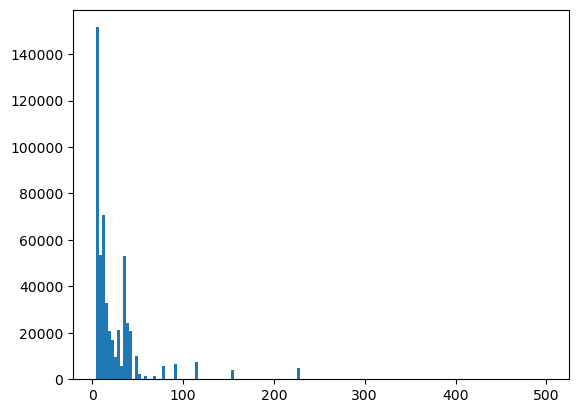

In [415]:
plt.hist(pred_depth.flatten(), bins=150);

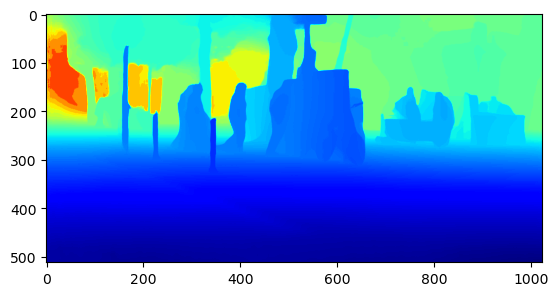

In [418]:
plt.imshow(np.log(pred_depth), cmap='jet')

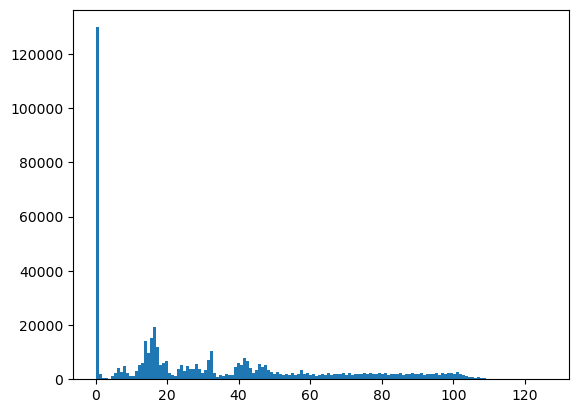

In [391]:
plt.hist(disparity.flatten(), bins=150);

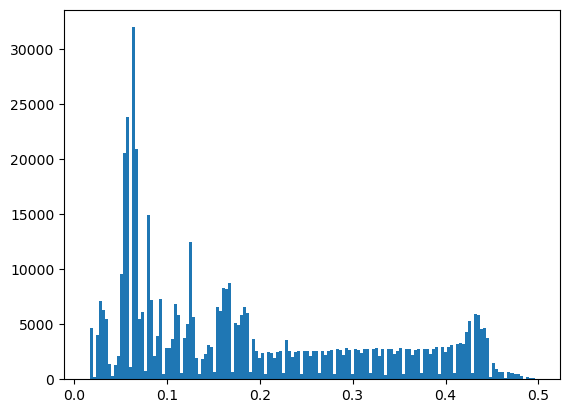

In [402]:
plt.hist(depth.flatten(), bins=150);

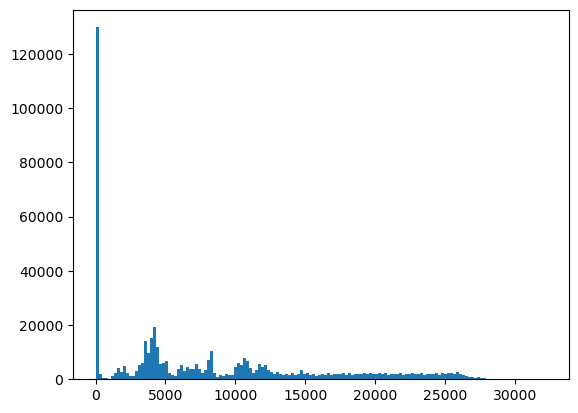

In [362]:
plt.hist(depth.flatten(), bins=150);